# Visualizations

In [2]:
# Importing libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px

In [3]:
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, coint
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns

In [3]:
# importing bitcoin price data
btc = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/btc_clean.csv', index_col = False)

In [4]:
# importing google trends
gtrends = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/gtrends_clean.csv', index_col = False)

In [4]:
# importing M2 Money Supply
M2 = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/M2_clean.csv', index_col = False)

In [6]:
# importing S&P500 data
sp500 = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/sp500_clean.csv', index_col = False)

In [108]:
# importing treasury yields
yields = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/yields_clean.csv', index_col = False)

In [5]:
btc.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [6]:
# Convert Unix timestamp to datetime
btc["Timestamp"] = pd.to_datetime(btc["Timestamp"], unit="s")

# format to YYYY-MM-DD (string) if you want it clean in the DataFrame
btc["Timestamp"] = btc["Timestamp"].dt.strftime("%Y-%m-%d")


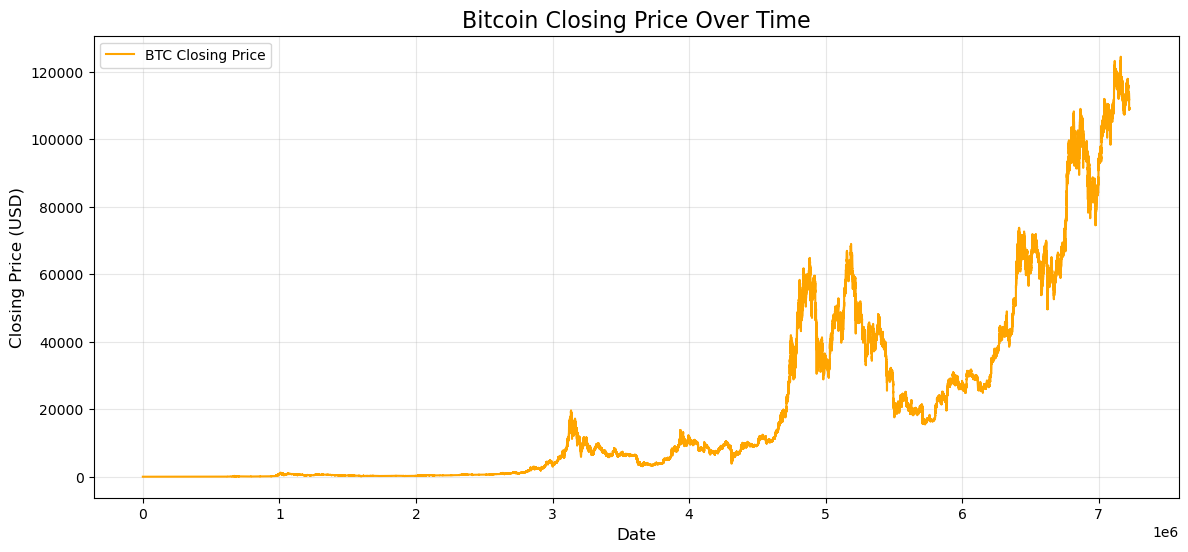

In [40]:
# Plot closing price
plt.figure(figsize=(14, 6))
plt.plot(btc.index, btc['Close'], label='BTC Closing Price', color='orange')

# Add labels & title
plt.title("Bitcoin Closing Price Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Closing Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Save the figure in the specified folder
plt.savefig(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/04 Analysis/bitcoin_closing_price.png', dpi=300)

plt.show()

In [7]:
M2.head()

,observation_date,M2SL
0,2015-08-01,12093.7
1,2015-08-02,12093.7
2,2015-08-03,12093.7
3,2015-08-04,12093.7
4,2015-08-05,12093.7


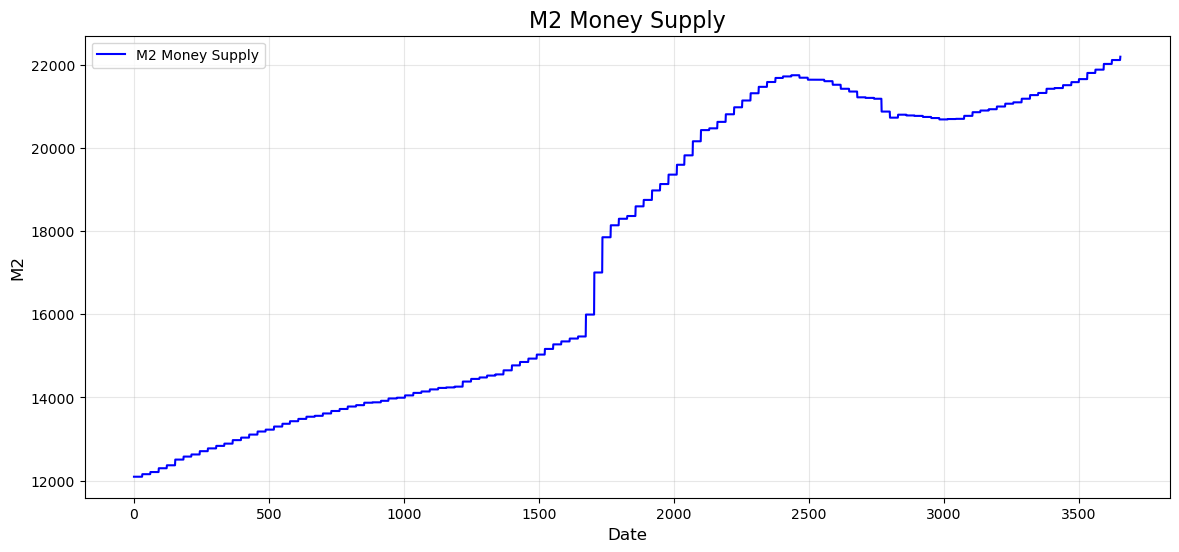

In [147]:
# Plot M2SL
plt.figure(figsize=(14, 6))
plt.plot(M2.index, M2['M2SL'], label='M2 Money Supply', color='blue')

# Add labels & title
plt.title("M2 Money Supply", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("M2", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

# Check for correlation between M2 Money Supply and BTC price

In [8]:
M2["observation_date"] = pd.to_datetime(M2["observation_date"])
btc["Timestamp"] = pd.to_datetime(btc["Timestamp"])

In [9]:
# round BTC to monthly
btc["month"] = btc["Timestamp"].dt.to_period("M").dt.to_timestamp()
M2["month"] = M2["observation_date"].dt.to_period("M").dt.to_timestamp()

In [10]:
#monthly average of BTC
btc_monthly = btc.groupby("month")["Close"].mean().reset_index()

In [11]:
# merge data sets
merged = pd.merge(M2, btc_monthly, on="month", how="inner")

In [12]:
merged.to_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/m2btc.csv', index=False)

In [13]:
merged.head(10)

,observation_date,M2SL,month,Close
0,2015-08-01,12093.7,2015-08-01,252.960275
1,2015-08-02,12093.7,2015-08-01,252.960275
2,2015-08-03,12093.7,2015-08-01,252.960275
3,2015-08-04,12093.7,2015-08-01,252.960275
4,2015-08-05,12093.7,2015-08-01,252.960275
5,2015-08-06,12093.7,2015-08-01,252.960275
6,2015-08-07,12093.7,2015-08-01,252.960275
7,2015-08-08,12093.7,2015-08-01,252.960275
8,2015-08-09,12093.7,2015-08-01,252.960275
9,2015-08-10,12093.7,2015-08-01,252.960275


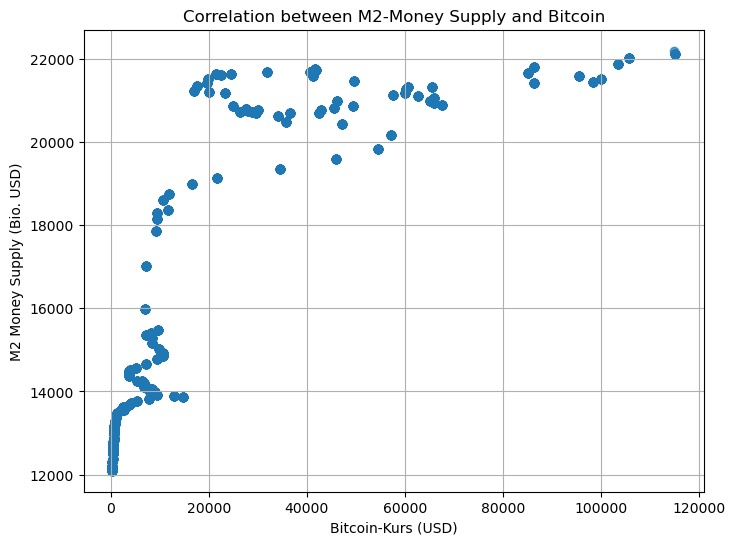

In [177]:
# plot scatterplot
plt.figure(figsize=(8,6))
plt.scatter(merged["Close"], merged["M2SL"], alpha=0.7)
plt.xlabel("Bitcoin-Kurs (USD)")
plt.ylabel("M2 Money Supply (Bio. USD)")
plt.title("Correlation between M2-Money Supply and Bitcoin")
plt.grid(True)


plt.show()

In [178]:
# calculate correlation
corr, pval = pearsonr(merged["Close"], merged["M2SL"])
print(f"Korrelation (r): {corr:.3f}")
print(f"P-Wert: {pval:.3e}")

Korrelation (r): 0.776
P-Wert: 0.000e+00


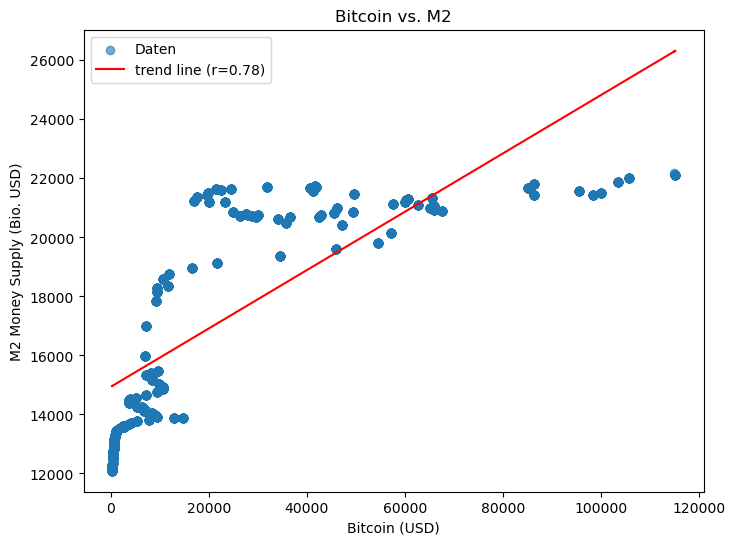

In [179]:
# with correlation line
import numpy as np

x = merged["Close"]
y = merged["M2SL"]
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.6, label="Daten")
plt.plot(x, m*x + b, color="red", label=f"trend line (r={corr:.2f})")
plt.xlabel("Bitcoin (USD)")
plt.ylabel("M2 Money Supply (Bio. USD)")
plt.title("Bitcoin vs. M2")
plt.legend()

plt.savefig(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/04 Analysis/BTC_M2_trend_line.png', dpi=300)
plt.show()

There is a statiscially significant correlation between the two varbiables.

# Granger Causality Test

In [35]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Only relevant columns
data = merged[["M2SL", "Close"]].dropna()

# test for stationarity
for col in data.columns:
    result = adfuller(data[col])
    print(f"{col}: p-Wert = {result[1]:.4f}")

M2SL: p-Wert = 0.8055
Close: p-Wert = 0.9918


In [36]:
data_diff = data.diff().dropna()

In [37]:
from statsmodels.tsa.stattools import grangercausalitytests

# maxlag = 3 test 1 to 3 months lag
granger_result = grangercausalitytests(data_diff, maxlag=3, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0133  , p=0.9082  , df_denom=3649, df_num=1
ssr based chi2 test:   chi2=0.0133  , p=0.9082  , df=1
likelihood ratio test: chi2=0.0133  , p=0.9082  , df=1
parameter F test:         F=0.0133  , p=0.9082  , df_denom=3649, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0135  , p=0.9866  , df_denom=3646, df_num=2
ssr based chi2 test:   chi2=0.0271  , p=0.9866  , df=2
likelihood ratio test: chi2=0.0271  , p=0.9866  , df=2
parameter F test:         F=0.0135  , p=0.9866  , df_denom=3646, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0137  , p=0.9978  , df_denom=3643, df_num=3
ssr based chi2 test:   chi2=0.0413  , p=0.9978  , df=3
likelihood ratio test: chi2=0.0413  , p=0.9978  , df=3
parameter F test:         F=0.0137  , p=0.9978  , df_denom=3643, df_num=3


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


There seems to be no causality

# Test Correlation between S&P500 and Bitcoin price

In [4]:
# importing bitcoin price data
btc_02 = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/btc_clean.csv', index_col = False)

In [5]:
btc_02.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [6]:
# Convert Unix timestamp to datetime
btc_02["Timestamp"] = pd.to_datetime(btc_02["Timestamp"], unit="s")

# format to YYYY-MM-DD (string) if you want it clean in the DataFrame
btc_02["Timestamp"] = btc_02["Timestamp"].dt.strftime("%Y-%m-%d")

In [7]:
btc_02.head()

,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01,4.58,4.58,4.58,4.58,0.0
1,2012-01-01,4.58,4.58,4.58,4.58,0.0
2,2012-01-01,4.58,4.58,4.58,4.58,0.0
3,2012-01-01,4.58,4.58,4.58,4.58,0.0
4,2012-01-01,4.58,4.58,4.58,4.58,0.0


In [8]:
# importing S&P500 data
sp500 = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/sp500_clean.csv', index_col = False)

In [9]:
sp500.head()

,observation_date,SP500
0,2015-09-28,1881.77
1,2015-09-29,1884.09
2,2015-09-30,1920.03
3,2015-10-01,1923.82
4,2015-10-02,1951.36


/var/folders/bz/7hwgnc95287cp83lwy4gfzth0000gn/T/ipykernel_17379/1143847292.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  btc_monthly = btc_02['Close'].resample('M').last()
/var/folders/bz/7hwgnc95287cp83lwy4gfzth0000gn/T/ipykernel_17379/1143847292.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_monthly = sp500['SP500'].resample('M').last()


Pearson correlation coefficient: 0.944, p-value: 0.000


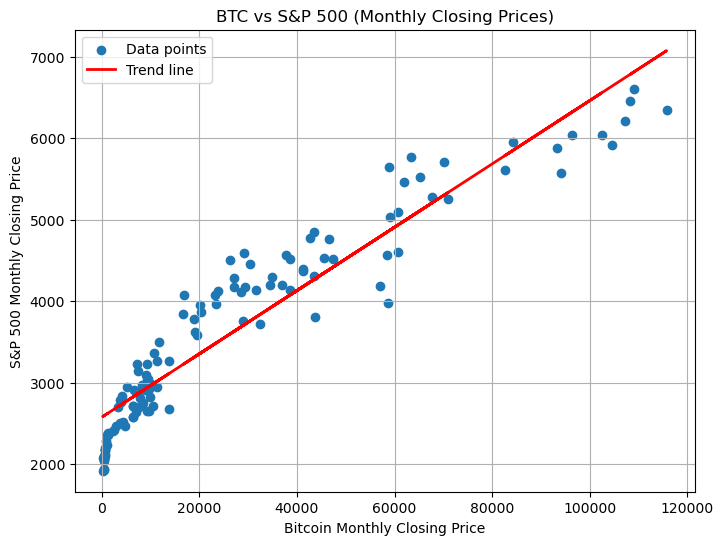

In [10]:
# create scatter plot

# Convert date columns to datetime
btc_02['Timestamp'] = pd.to_datetime(btc_02['Timestamp'])
sp500['observation_date'] = pd.to_datetime(sp500['observation_date'])

# Set date columns as index
btc_02.set_index('Timestamp', inplace=True)
sp500.set_index('observation_date', inplace=True)

# Resample to monthly frequency and take the last price of each month
btc_monthly = btc_02['Close'].resample('M').last()
sp500_monthly = sp500['SP500'].resample('M').last()

# Merge the monthly data on dates
merged_monthly = pd.merge(btc_monthly, sp500_monthly, left_index=True, right_index=True, how='inner')

# Compute correlation
corr_coef, p_value = pearsonr(merged_monthly['Close'], merged_monthly['SP500'])
print(f"Pearson correlation coefficient: {corr_coef:.3f}, p-value: {p_value:.3f}")

# Fit a linear regression line
slope, intercept = np.polyfit(merged_monthly['Close'], merged_monthly['SP500'], 1)
trend_line = slope * merged_monthly['Close'] + intercept

# Scatter plot with trend line
plt.figure(figsize=(8,6))
plt.scatter(merged_monthly['Close'], merged_monthly['SP500'], label='Data points')
plt.plot(merged_monthly['Close'], trend_line, color='red', linewidth=2, label='Trend line')
plt.xlabel('Bitcoin Monthly Closing Price')
plt.ylabel('S&P 500 Monthly Closing Price')
plt.title('BTC vs S&P 500 (Monthly Closing Prices)')
plt.legend()
plt.grid(True)
plt.show()


a correlation coefficient of 0.944 indicates a strong positive correlation

# Create correlation heat map

In [11]:
merged_monthly.to_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/btcspc.csv', index=False)

In [92]:
# importing bitcoin price data
btc_02 = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/btc_clean.csv', index_col = False)

# importing S&P500 data
sp500 = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/sp500_clean.csv', index_col = False)

# importing M2 Money Supply
M2 = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/M2_clean.csv', index_col = False)

       BTC  SP500  M2
BTC    NaN    NaN NaN
SP500  NaN    NaN NaN
M2     NaN    NaN NaN


/var/folders/bz/7hwgnc95287cp83lwy4gfzth0000gn/T/ipykernel_41963/2577910794.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  btc_monthly = btc_02['Close'].resample('M').last()
/var/folders/bz/7hwgnc95287cp83lwy4gfzth0000gn/T/ipykernel_41963/2577910794.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_monthly = sp500['SP500'].resample('M').last()
/var/folders/bz/7hwgnc95287cp83lwy4gfzth0000gn/T/ipykernel_41963/2577910794.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  M2_monthly = M2['M2SL'].resample('M').last()
/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


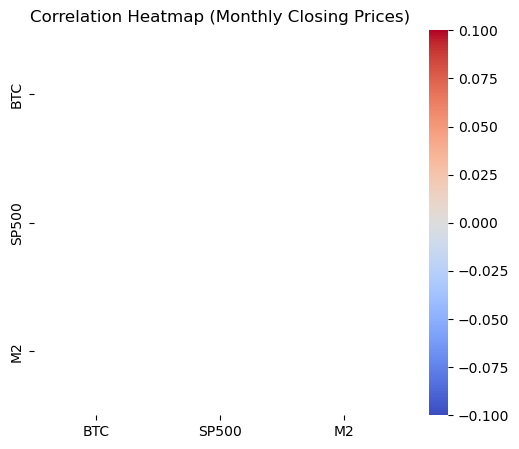

In [93]:
# Convert date columns to datetime
btc_02['Timestamp'] = pd.to_datetime(btc_02['Timestamp'])
sp500['observation_date'] = pd.to_datetime(sp500['observation_date'])
M2['observation_date'] = pd.to_datetime(M2['observation_date'])

# Set date as index
btc_02.set_index('Timestamp', inplace=True)
sp500.set_index('observation_date', inplace=True)
M2.set_index('observation_date', inplace=True)

# Resample to monthly frequency and take last value
btc_monthly = btc_02['Close'].resample('M').last()
sp500_monthly = sp500['SP500'].resample('M').last()
M2_monthly = M2['M2SL'].resample('M').last()

# Merge all datasets on dates
merged_monthly = pd.concat([btc_monthly, sp500_monthly, M2_monthly], axis=1)
merged_monthly.columns = ['BTC', 'SP500', 'M2']

# Drop any rows with missing values
merged_monthly.dropna(inplace=True)

# Compute correlation matrix (for prices)
corr_matrix = merged_monthly.corr()
print(corr_matrix)

# Plot heat map
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Monthly Closing Prices)')
plt.show()


Creating a correlation heat map with three different data sets is honestly a bit over my head

# Yield analysis

In [134]:
# importing treasury yields
yields = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/yields_clean.csv', index_col = False)

# importing bitcoin price data
btc = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/btc_clean.csv', index_col = False)

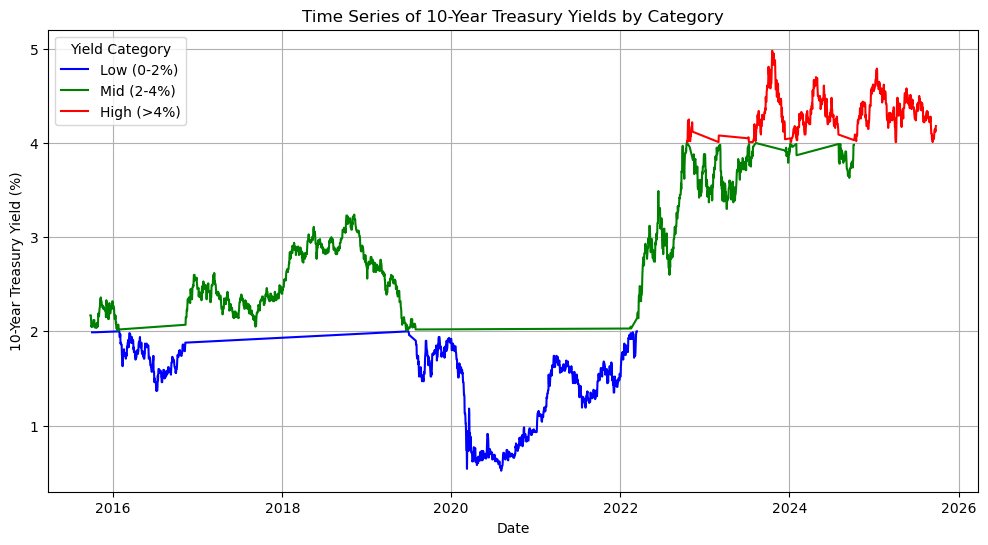

In [131]:
# Convert date and set index
yields['observation_date'] = pd.to_datetime(yields['observation_date'])
yields.set_index('observation_date', inplace=True)

# Categorize yields
bins = [0, 2, 4, float('inf')]
labels = ['Low (0-2%)', 'Mid (2-4%)', 'High (>4%)']
yields['Yield_Category'] = pd.cut(yields['DGS10'], bins=bins, labels=labels)

# Plot time series with different colors
plt.figure(figsize=(12,6))

# Define colors for categories
colors = {'Low (0-2%)':'blue', 'Mid (2-4%)':'green', 'High (>4%)':'red'}

# Loop through the data and plot segments by category
for cat in labels:
    data_cat = yields[yields['Yield_Category'] == cat]
    plt.plot(data_cat.index, data_cat['DGS10'], color=colors[cat], label=cat)

plt.xlabel('Date')
plt.ylabel('10-Year Treasury Yield (%)')
plt.title('Time Series of 10-Year Treasury Yields by Category')
plt.legend(title='Yield Category')
plt.grid(True)
plt.show()


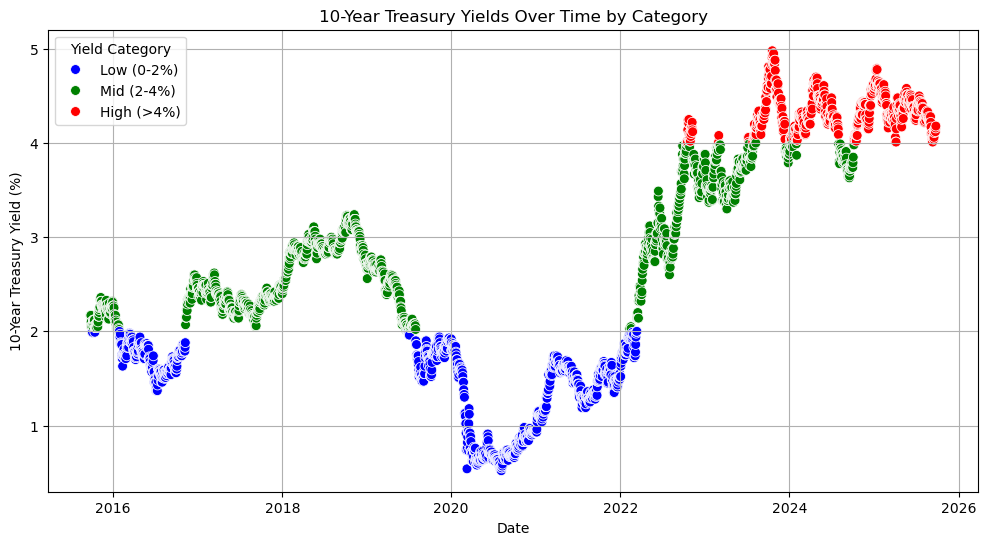

In [135]:
# Convert date and set index
yields['observation_date'] = pd.to_datetime(yields['observation_date'])
yields.set_index('observation_date', inplace=True)

# Categorize yields
bins = [0, 2, 4, float('inf')]
labels = ['Low (0-2%)', 'Mid (2-4%)', 'High (>4%)']
yields['Yield_Category'] = pd.cut(yields['DGS10'], bins=bins, labels=labels)

# Scatter plot
plt.figure(figsize=(12,6))
sns.scatterplot(
    x=yields.index,
    y=yields['DGS10'],
    hue=yields['Yield_Category'],
    palette={'Low (0-2%)':'blue', 'Mid (2-4%)':'green', 'High (>4%)':'red'},
    s=50
)
plt.xlabel('Date')
plt.ylabel('10-Year Treasury Yield (%)')
plt.title('10-Year Treasury Yields Over Time by Category')
plt.legend(title='Yield Category')
plt.grid(True)
plt.savefig(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/04 Analysis/treasury_yields.png', dpi=300)
plt.show()